Imports and constants assignation

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


### Constants
samples_per_record = 3327
fs = 16000
inputs = []
outputs = []
flag = True


# List of commands that the nn will recognize
# commands = ['now', 'take','fetch','noise','cancel','driver','pillow','slider','rod','stop','wrench','piston','crank']
commands = ['slider','driver','noise']
num_commands = len(commands)

# create a one-hot encoded matrix that is used in the output
encoded_commands = np.eye(num_commands)

# Definir los parámetros para el espectrograma
win = np.hamming(1024)
nfft = 1024
hop = nfft // 2


Data parse

In [31]:

# read each csv file and push an input and output
for command_idx in range(num_commands):
  command = commands[command_idx]
  print(f"Processing index {command_idx} for command '{command}'.")
  
  output = encoded_commands[command_idx]
  
  df = np.loadtxt("data_set/" + command + ".txt")
  
  # calculate the number of command recordings in the file
  num_recordings = int(df.shape[0] / samples_per_record)
  
  print(f"\tThere are {num_recordings} recordings of the {command} command.")
  
  for i in range(num_recordings):
    tensor = []
    start = i*samples_per_record
    end = start+samples_per_record
    spec, freqs, times, _ = plt.specgram(df[start:end], NFFT=nfft, Fs=fs, window=win, noverlap=hop, mode='magnitude')
    plt.close()
    tensor = spec

    inputs.append(tensor)
    outputs.append(output)
  print('\tSorting ',command)
  
  # convert the list to numpy array
  inputs = np.array(inputs)
  outputs = np.array(outputs)

  if flag:
      inputs_train = np.empty((0,inputs.shape[1],inputs.shape[2]))
      inputs_test = np.empty((0,513,5))
      inputs_validate = np.empty((0,513,5))
      outputs_train = np.empty((0,outputs.shape[1]))
      outputs_test = np.empty((0,outputs.shape[1]))
      outputs_validate = np.empty((0,outputs.shape[1]))
      temp_inputs_train = np.empty((0,513,5))
      temp_inputs_test = np.empty((0,513,5))
      temp_inputs_validate = np.empty((0,513,5))
      temp_outputs_train = np.empty((0,outputs.shape[1]))
      temp_outputs_test = np.empty((0,outputs.shape[1]))
      temp_outputs_validate = np.empty((0,outputs.shape[1]))
      flag = False

  # Sort inputs randomly
  num_inputs = len(inputs)
  random_idx = np.arange(num_inputs)
  np.random.shuffle(random_idx)

  inputs = inputs[random_idx]
  outputs = outputs[random_idx]

  # Split the inputs into: training (60%), testing(20%) and validation(20%)
  train_idx = int(0.6 * num_inputs)
  test_idx = int(0.2 * num_inputs + train_idx)

  temp_inputs_train, temp_inputs_test, temp_inputs_validate = np.split(inputs, [train_idx, test_idx])
  temp_outputs_train, temp_outputs_test, temp_outputs_validate = np.split(outputs, [train_idx, test_idx])
  
  
  inputs_train = np.vstack([inputs_train, temp_inputs_train])
  inputs_test = np.vstack([inputs_test, temp_inputs_test])
  inputs_validate = np.vstack([inputs_validate, temp_inputs_validate])
  print('Inputs train shape: ',inputs_train.shape)

  outputs_train = np.vstack([outputs_train, temp_outputs_train])
  outputs_test = np.vstack([outputs_test, temp_outputs_test])
  outputs_validate = np.vstack([outputs_validate, temp_outputs_validate])

  inputs = []
  outputs = [] 

print("Data set parsing and preparation complete.")

Processing index 0 for command 'slider'.
	There are 121 recordings of the slider command.
	Sorting  slider
Inputs train shape:  (72, 513, 5)
Processing index 1 for command 'driver'.
	There are 103 recordings of the driver command.
	Sorting  driver
Inputs train shape:  (133, 513, 5)
Processing index 2 for command 'noise'.
	There are 105 recordings of the noise command.
	Sorting  noise
Inputs train shape:  (196, 513, 5)
Data set parsing and preparation complete.


Randomize samples

In [32]:

num_inputs = len(inputs_train)
random_idx = np.arange(num_inputs)
np.random.shuffle(random_idx)

inputs_train = inputs_train[random_idx]
outputs_train = outputs_train[random_idx]

# Ajustar la forma de los datos de entrada
inputs_train = np.expand_dims(inputs_train, axis=1)
inputs_validate = np.expand_dims(inputs_validate, axis=1)
inputs_test = np.expand_dims(inputs_test, axis=1)

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


Model training and bulding

In [44]:
# build the model and train it

# Define the input shape
input_shape = inputs_train[1].shape

# Define the number of filters and filter sizes for the first layer
filters_layer_1 = 8
filter_size_layer_1 = (3,3)
model = 0
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=filters_layer_1, padding='same', kernel_size=filter_size_layer_1,activation='relu', input_shape=input_shape))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*2, padding='same', kernel_size=filter_size_layer_1,activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(num_commands, activation='softmax'))
# model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
# optimizer= adam loss= crossentropy metrics = accuracy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(inputs_train, outputs_train, epochs=30, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Epoch 1/30
196/196 [==============================] - 1s 2ms/step - loss: 0.5903 - accuracy: 0.7449 - val_loss: 0.2946 - val_accuracy: 0.9118
Epoch 2/30
196/196 [==============================] - 0s 1ms/step - loss: 0.1969 - accuracy: 0.9490 - val_loss: 0.2449 - val_accuracy: 0.9118
Epoch 3/30
196/196 [==============================] - 0s 1ms/step - loss: 0.0709 - accuracy: 0.9796 - val_loss: 0.2833 - val_accuracy: 0.8971
Epoch 4/30
196/196 [==============================] - 0s 1ms/step - loss: 0.0571 - accuracy: 0.9745 - val_loss: 0.3201 - val_accuracy: 0.8235
Epoch 5/30
196/196 [==============================] - 0s 1ms/step - loss: 0.0447 - accuracy: 0.9796 - val_loss: 0.1021 - val_accuracy: 0.9412
Epoch 6/30
196/196 [==============================] - 0s 1ms/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 0.1774 - val_accuracy: 0.9265
Epoch 7/30
196/196 [==============================] - 0s 1ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.1450 - val_accuracy: 0.9118
Epoch 

Loss graph

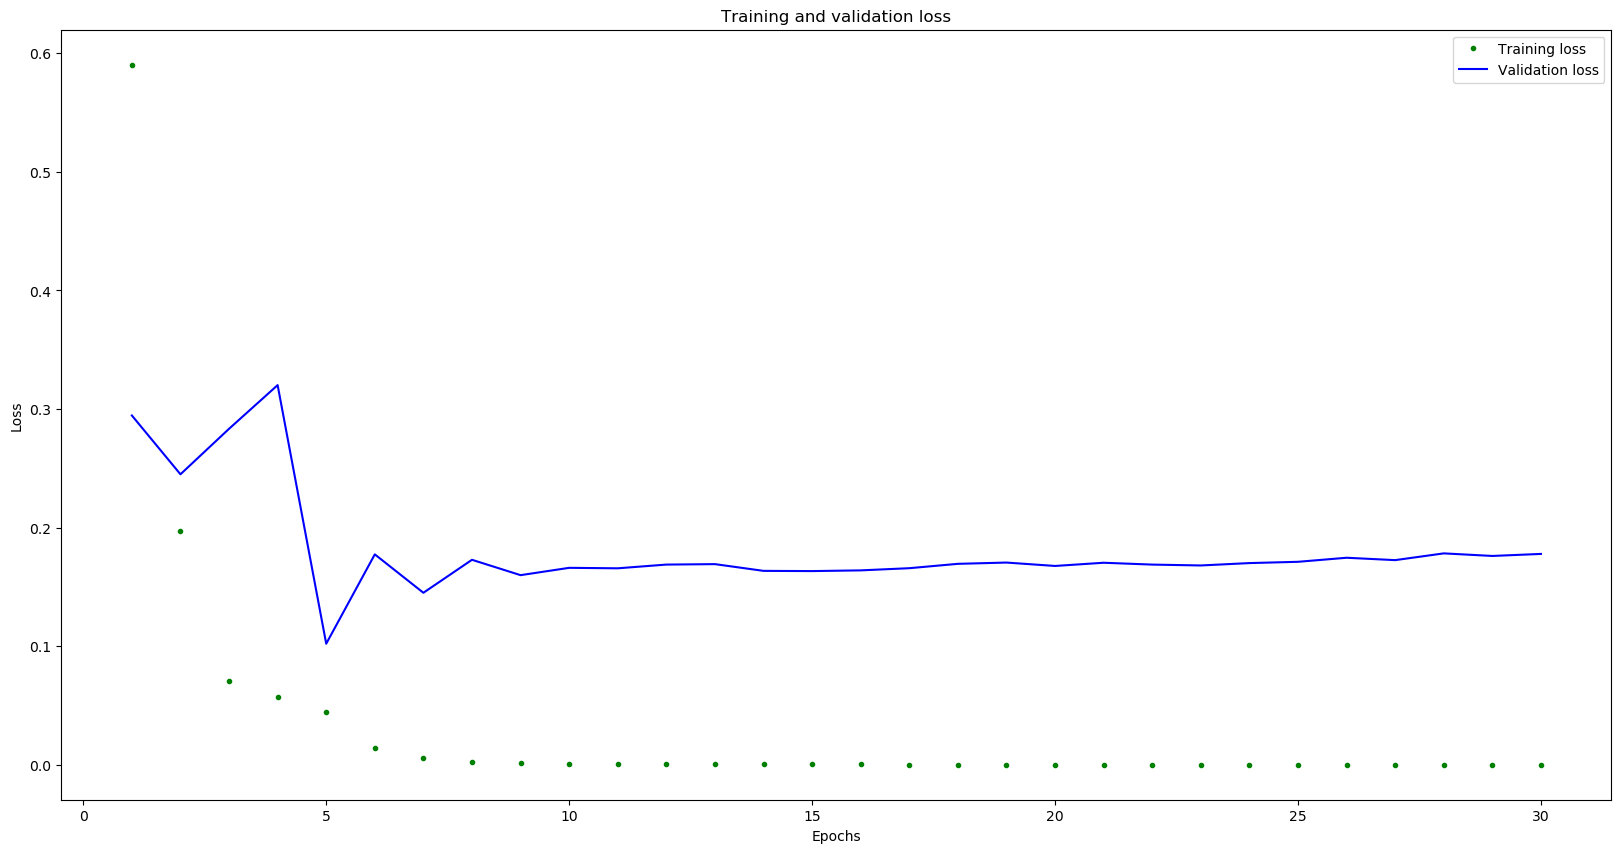

In [45]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


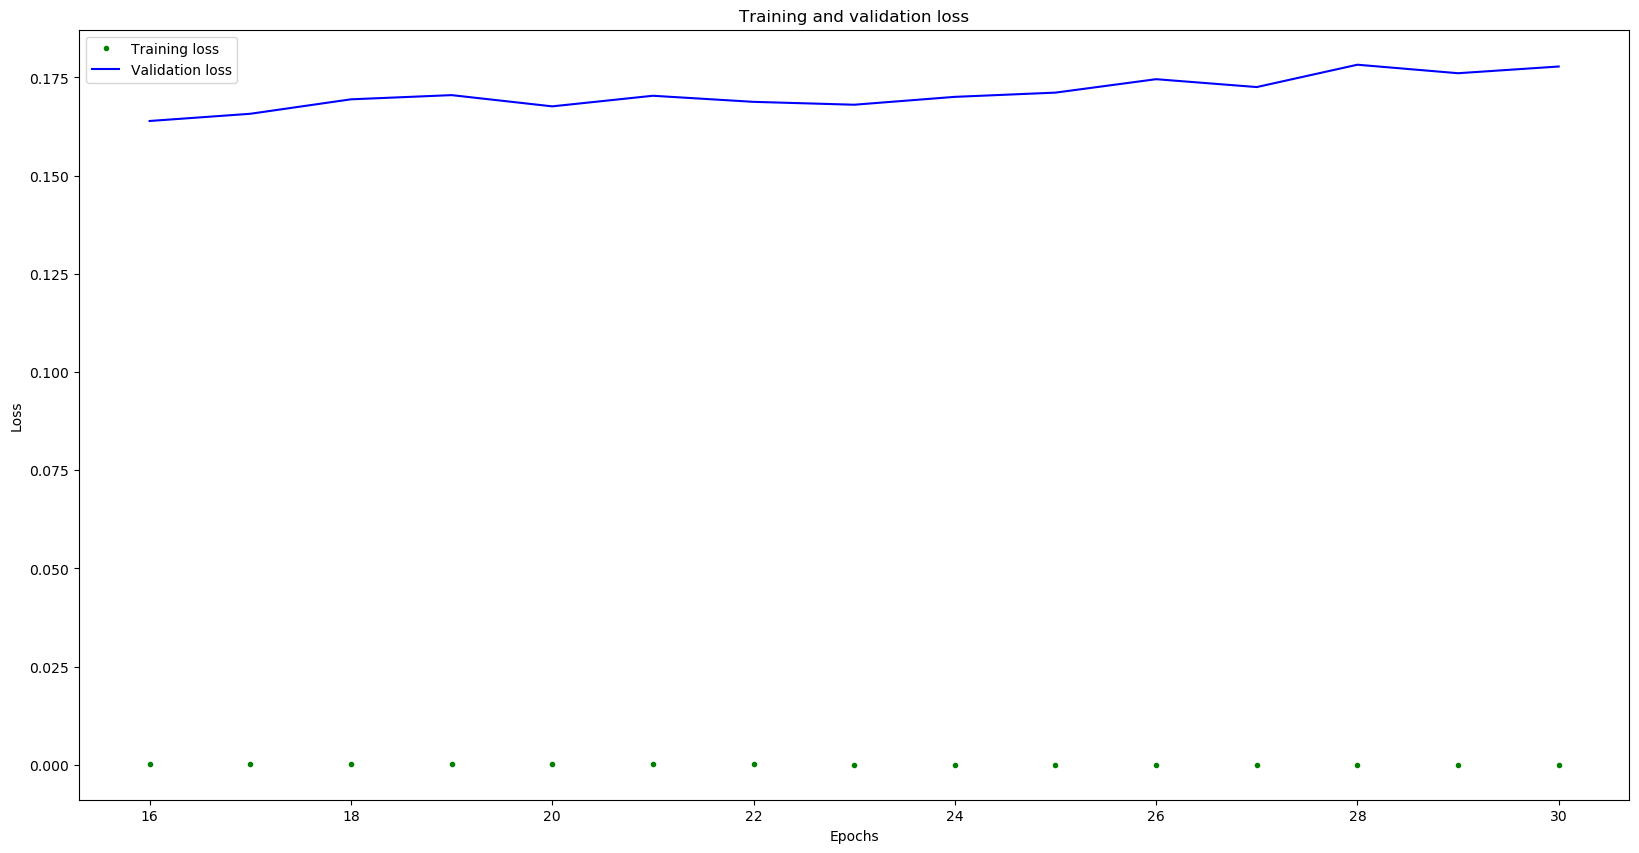

In [46]:
# graph the loss again skipping a bit of the start
SKIP = int(len(epochs)/2)
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Accuracy graph

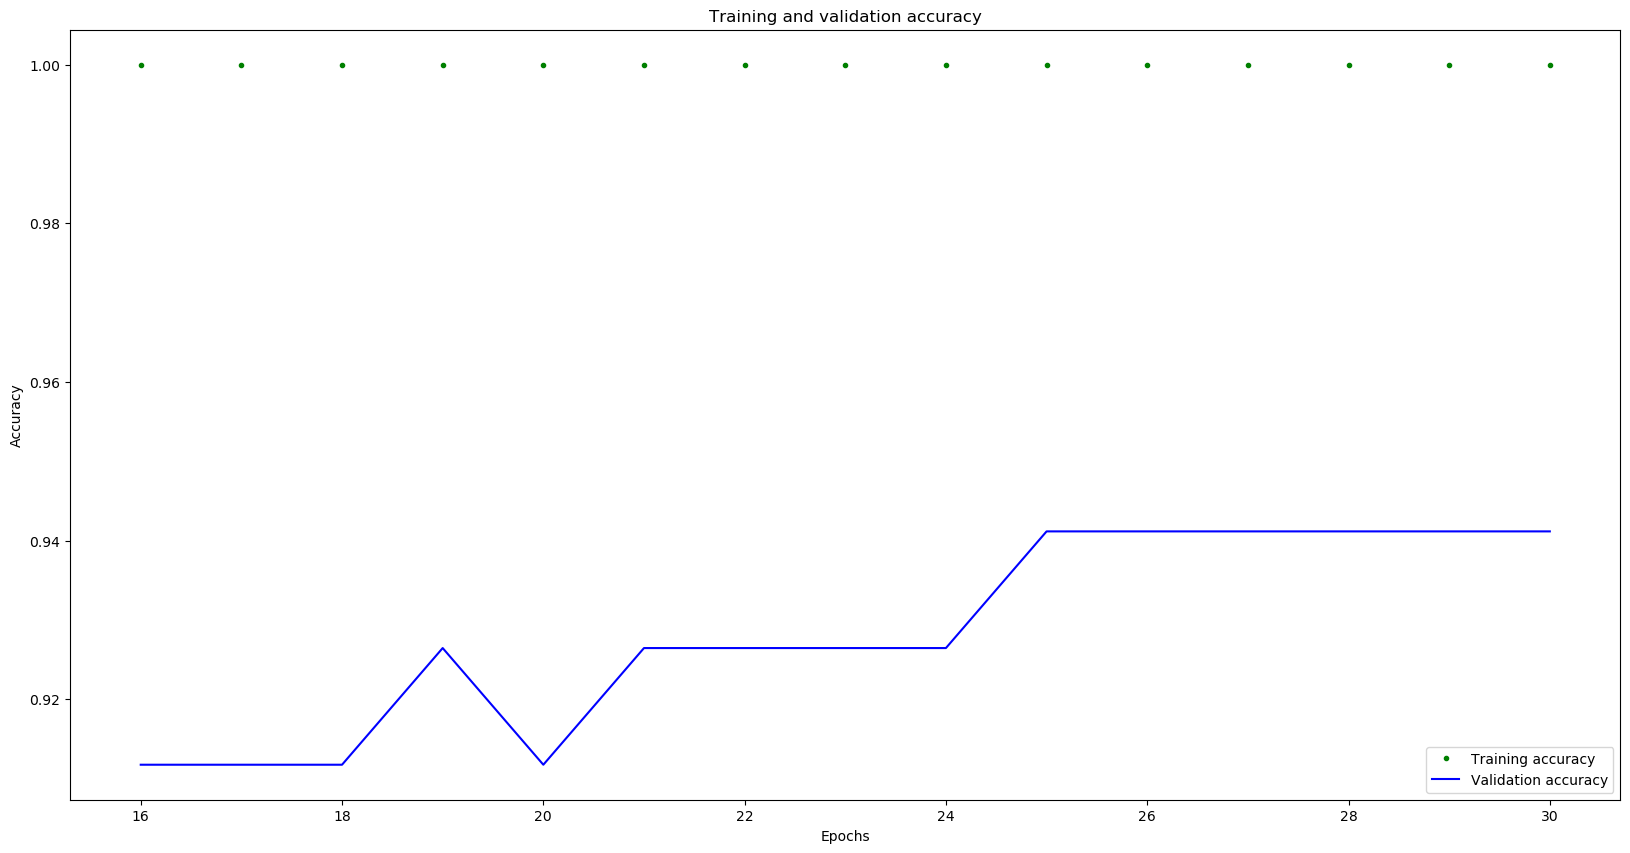

In [47]:
# graph of accuracy
mae = history.history['accuracy']
val_mae = history.history['val_accuracy']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training accuracy')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Test model predictions

3/3 [==============================] - 0s 2ms/step
class: 3
[[22.  2.  0.]
 [ 2. 17.  1.]
 [ 0.  1. 20.]]


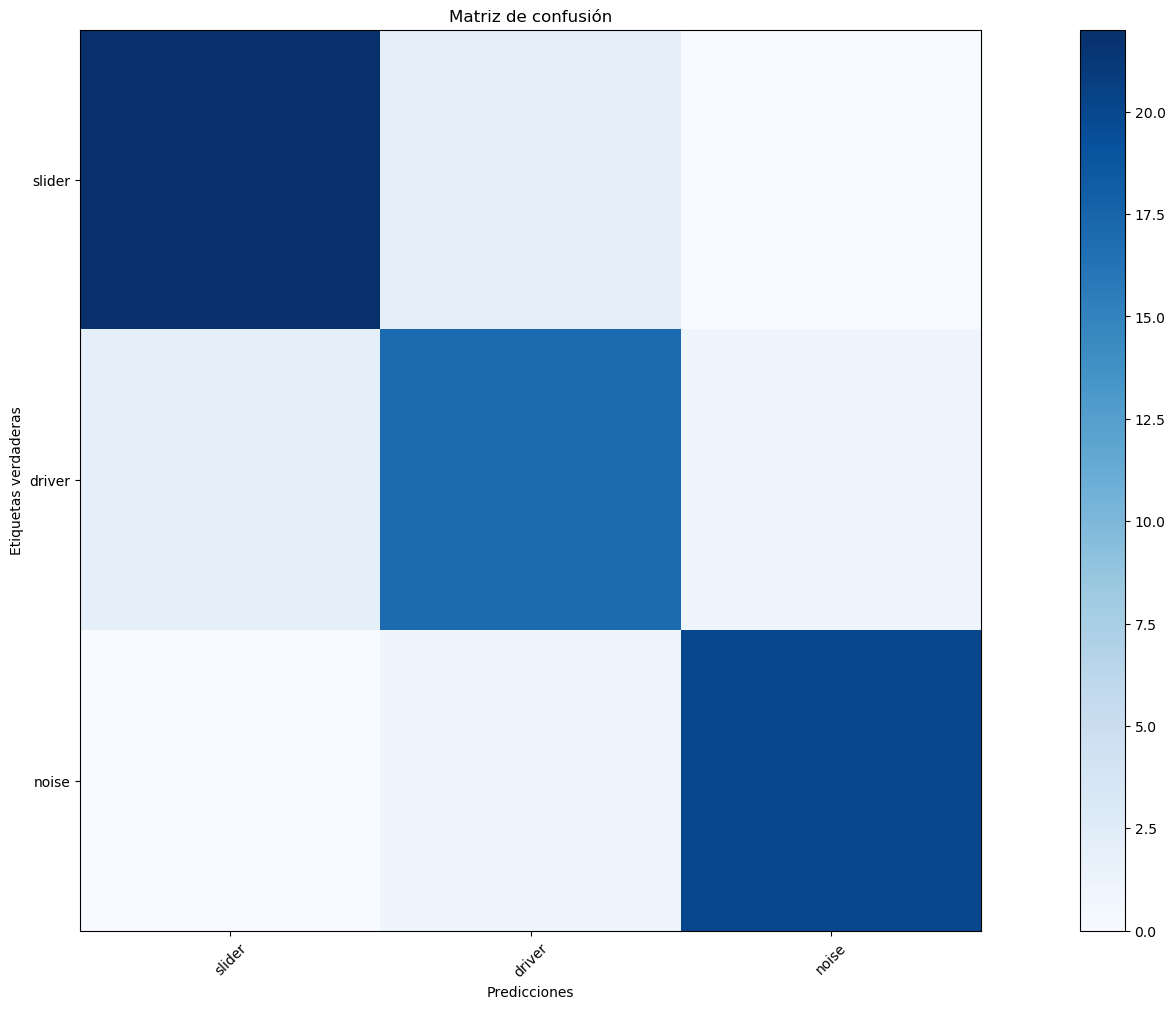

In [48]:
# use the model to predict the test inputs
# inputs_test = np.expand_dims(inputs_test, axis=1)
predictions = model.predict(inputs_test)

import numpy as np
import matplotlib.pyplot as plt

# Calcula la matriz de confusión utilizando NumPy
num_classes = len((outputs_test[1]))
print('class:',num_classes)
confusion_matrix = np.zeros((num_classes, num_classes))

for i in range(len(outputs_test)):
    true_class = np.argmax(outputs_test[i])
    predicted_class = np.argmax(predictions[i])
    confusion_matrix[true_class][predicted_class] += 1
print(confusion_matrix)

# Imprime la matriz de confusión utilizando la biblioteca matplotlib.pyplot
plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
plt.title("Matriz de confusión")
plt.colorbar()
tick_marks = np.arange(len(commands))
plt.xticks(tick_marks, commands, rotation=45)
plt.yticks(tick_marks, commands)
plt.tight_layout()
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()


Convert model to tensorflow lite

In [49]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("command_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("command_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /tmp/tmphl4a3kii/assets


INFO:tensorflow:Assets written to: /tmp/tmphl4a3kii/assets


Model is 529904 bytes


2023-05-10 10:11:13.767301: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-10 10:11:13.767333: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-10 10:11:13.767573: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphl4a3kii
2023-05-10 10:11:13.768580: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-10 10:11:13.768598: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphl4a3kii
2023-05-10 10:11:13.772072: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-05-10 10:11:13.809490: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmphl4a3kii
2023-05-10 10:11:13.818649: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 51076 m